<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/JuhongPark/snu-fintech-ai/blob/main/Lending_Club_SSAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# 데이터 가져오기 및 전처리

In [38]:
# 테스트런 설정
is_test = True

In [39]:
# seed 값 설정
seed = 42

# 입력 변수 파라미터
target = 'loan_status_encoded'
drop_list = ['id', 'int_rate', 'installment', 'sub_grade']
feature_list = ['loan_amnt', 'emp_length', 'revol_util', 'pub_rec', 'fico_range_high', 'fico_range_low', 'percent_bc_gt_75']

# 대출 이후 변수
post_list = ['Funded_amnt', 'funded_amnt_inv', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'last_credit_pull_d', 'last_pymnt_amnt', 'last_pymnt_d',
 'mths_since_last_major_derog', 'next_pymnt_d', 'out_prncp', 'out_prncp_inv', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee',
 'total_rec_prncp', 'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date',
 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount', 'debt_settlement_flag', 'last_fico_range_high', 'last_fico_range_low']

# 모델 파라미터 설정
# For model
learning_rate = 0.01

# For training
n_epochs = 10000

# 테스트 런일 경우, 에포크 수를 줄임
if is_test:
    n_epochs = 10

In [40]:
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
import shap
from sklearn.ensemble import RandomForestClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgbm
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [41]:
# Random Seed 설정
def set_random_seed(seed):
    random.seed(seed) # 파이썬 표준 라이브러리
    np.random.seed(seed) # numpy의 random 모듈에서 사용하는 seed
    torch.manual_seed(seed) # pytorch에서 사용하는 seed
    if torch.cuda.is_available(): # GPU에서 실행되는 PyTorch 연산의 무작위성을 제어
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

In [42]:
# seed 값 설정
set_random_seed(seed)

## 데이터 다운로드하기

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
# 모든 행이 화면에 표시되도록 설정합니다.
# pd.set_option('display.max_rows', None)

# file_path = '/content/drive/MyDrive/SNUKDT/Lending Club/LC_Data_Cleaned_2.csv'
# df = pd.read_csv(file_path)


# 모든 행이 화면에 표시되도록 설정합니다.
pd.set_option('display.max_rows', None)

file_path = '../LendingClub/LC_Data_Cleaned_2.csv'
df = pd.read_csv(file_path)

# 테스트 런일 경우, 데이터 크기 줄이기
if is_test:
    df = df.sample(frac=0.01, random_state=seed)

## 데이터 구조 훑어 보기

In [22]:
df.head()

,id,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_encoded
0,6519928,12800.0,0,0.1433,439.53,C2,1.0,0,132500.0,1,...,3.0,88.0,50.0,0.0,0.0,393952.0,79834.0,8593.0,82659.0,0
1,26359465,24000.0,0,0.0769,748.65,A4,10.0,0,70000.0,0,...,0.0,100.0,100.0,0.0,0.0,126684.0,25691.0,22600.0,21384.0,0
2,13897978,18000.0,0,0.1249,602.08,B4,2.0,0,69500.0,0,...,2.0,97.8,100.0,0.0,0.0,271341.0,137583.0,4600.0,129718.0,1
3,15429979,5600.0,0,0.1099,183.32,B3,0.0,1,42000.0,0,...,1.0,88.9,100.0,0.0,0.0,22593.0,13074.0,2100.0,16093.0,0
4,8975826,5600.0,0,0.1620,197.44,C4,4.0,1,60000.0,0,...,1.0,100.0,100.0,0.0,0.0,51804.0,41327.0,19600.0,28775.0,1


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75090 entries, 0 to 75089
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              75090 non-null  int64  
 1   loan_amnt                       75090 non-null  float64
 2   term                            75090 non-null  int64  
 3   int_rate                        75090 non-null  float64
 4   installment                     75090 non-null  float64
 5   sub_grade                       75090 non-null  object 
 6   emp_length                      75090 non-null  float64
 7   home_ownership                  75090 non-null  int64  
 8   annual_inc                      75090 non-null  float64
 9   verification_status             75090 non-null  int64  
 10  dti                             75090 non-null  float64
 11  delinq_2yrs                     75090 non-null  float64
 12  earliest_cr_line                

In [24]:
df.shape

(75090, 61)

In [25]:
df.dtypes

id                                  int64
loan_amnt                         float64
term                                int64
int_rate                          float64
installment                       float64
sub_grade                          object
emp_length                        float64
home_ownership                      int64
annual_inc                        float64
verification_status                 int64
dti                               float64
delinq_2yrs                       float64
earliest_cr_line                  float64
fico_range_low                    float64
fico_range_high                   float64
inq_last_6mths                    float64
mths_since_last_delinq            float64
mths_since_last_record            float64
open_acc                          float64
pub_rec                           float64
revol_bal                         float64
revol_util                        float64
total_acc                         float64
last_credit_pull_d                

## 데이터 전처리

In [27]:
# 기존 df 에 있는 칼럼 중에서, drop_list 및 post_list의 칼럼 제거
drop_list = set(df.columns) & set(drop_list + post_list)

# 불필요한 변수 Drop
df = df.drop(columns = drop_list)

# 범주형변수 처리
df = df.select_dtypes(include = [np.number])

# 결측치 처리
df = df.fillna(0)
df.head()

,loan_amnt,term,emp_length,home_ownership,annual_inc,verification_status,dti,delinq_2yrs,earliest_cr_line,fico_range_low,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_encoded
0,12800.0,0,1.0,0,132500.0,1,9.78,0.0,15.665982,660.0,...,3.0,88.0,50.0,0.0,0.0,393952.0,79834.0,8593.0,82659.0,0
1,24000.0,0,10.0,0,70000.0,0,17.32,0.0,18.250513,720.0,...,0.0,100.0,100.0,0.0,0.0,126684.0,25691.0,22600.0,21384.0,0
2,18000.0,0,2.0,0,69500.0,0,23.71,0.0,20.665298,675.0,...,2.0,97.8,100.0,0.0,0.0,271341.0,137583.0,4600.0,129718.0,1
3,5600.0,0,0.0,1,42000.0,0,12.14,0.0,15.000684,665.0,...,1.0,88.9,100.0,0.0,0.0,22593.0,13074.0,2100.0,16093.0,0
4,5600.0,0,4.0,1,60000.0,0,24.56,0.0,18.833676,695.0,...,1.0,100.0,100.0,0.0,0.0,51804.0,41327.0,19600.0,28775.0,1


In [28]:
X = df.drop(columns=[target])
y = df[target]

# 모델 선택과 훈련

## 테스트 세트 만들기

In [29]:
# Torch 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if not is_test else "cpu" 

In [30]:
# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## SSAE 모델 정의

In [18]:
# Denoising SSAE 모델 정의
class DenoisingSSAE(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingSSAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),

        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [19]:
# SSAE 변환기 클래스를 만들어 파이프라인에 통합
class SSAETransformer(nn.Module):
    def __init__(self, input_dim):
        super(SSAETransformer, self).__init__()
        self.ssae = DenoisingSSAE(input_dim).to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.ssae.parameters(), lr=0.01)

    def fit(self, X, y=None):
        X_train_noisy = self.add_noise(X)
        for epoch in range(10000):
            self.ssae.train()
            inputs = torch.FloatTensor(X_train_noisy).to(device)
            targets = torch.FloatTensor(X).to(device)
            outputs = self.ssae(inputs)
            loss = self.criterion(outputs, targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return self

    def transform(self, X):
        self.ssae.eval()
        X_encoded = self.ssae.encoder(torch.FloatTensor(X).to(device)).detach().cpu().numpy()
        return X_encoded

    def add_noise(self, data, noise_factor=0.2):
        noise = noise_factor * np.random.randn(*data.shape)
        noisy_data = data + noise
        noisy_data = np.clip(noisy_data, 0., 1.)
        return noisy_data

## 모델 평가함수 및 실행

In [20]:
# 평가함수 정의
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [21]:
# ShapleyValue 계산, 시각화함수 정의
def evaluate_models_shap1(model, X_train_encoded_ssae, X_test_encoded_ssae):
    # Independent Masker와 LinearExplainer를 사용한 Shapley Value 계산
    masker = shap.maskers.Independent(X_train_encoded_ssae)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])

def evaluate_models_shap2(model, X_test_encoded_ssae):
    # TreeExplainer를 사용한 Shapley Value 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])


In [24]:
# ShapleyValue 계산, 시각화함수 정의 (TabNet 전용)
def evaluate_models_shap_tabnet(model, X_train_encoded_ssae, X_test_encoded_ssae):
    # DeepExplainer를 사용한 Shapley Value 계산 (TabNet 전용)
    explainer = DeepExplainer(model, X_train_encoded_ssae)
    shap_values = explainer.shap_values(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])

In [22]:
# SSAE + 모델을 위한 파이프라인 정의
ssae_transformer = SSAETransformer(input_dim=X_train.shape[1])

# 모델 정의 및 파이프라인 연결
linear_models = {
    "Logistic Regression": Pipeline([
        ('ssae', ssae_transformer),    # SSAE 추가
        ('model', LogisticRegression(max_iter=1000))  # 최종 모델
    ]),
}

ensemble_models = {
    "Random Forest Classifier": Pipeline([
        ('ssae', ssae_transformer),    # SSAE 추가
        ('model', RandomForestClassifier())  # 최종 모델
    ]),
    "XGBoost Classifier": Pipeline([
        ('ssae', ssae_transformer),    # SSAE 추가
        ('model', xgb.XGBClassifier())  # 최종 모델
    ]),
    "LightGBM Classifier": Pipeline([
        ('ssae', ssae_transformer),    # SSAE 추가
        ('model', lgbm.LGBMClassifier())  # 최종 모델
    ]),
}

tabnet_model = {
    "TabNet Classifier": Pipeline([
        ('ssae', ssae_transformer),    # SSAE 추가
        ('model', TabNetClassifier())  # 최종 모델로 TabNet 추가
    ]), # TabNet 추가
}

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


## 테스트세트로 평가하기

In [ ]:
for model_name, pipeline in linear_models.items():
    print(f"** Evaluating {model_name} on SSAE Encoded Data: ")
    evaluate_model(pipeline, X_train, X_test, y_train, y_test)

    X_test_encoded_ssae = pipeline.named_steps['ssae'].transform(X_test)
    X_train_encoded_ssae = pipeline.named_steps['ssae'].transform(X_train)

    print(f"** Evaluating {model_name}'s Shapley Value (LinearExplainer): ")
    evaluate_models_shap1(pipeline.named_steps['model'], X_train_encoded_ssae, X_test_encoded_ssae)


** Evaluating Random Forest Classifier on SSAE Encoded Data: 
Accuracy: 0.5534, Precision: 0.5552, Recall: 0.5375, F1 Score: 0.5462, R² Score: -0.7864


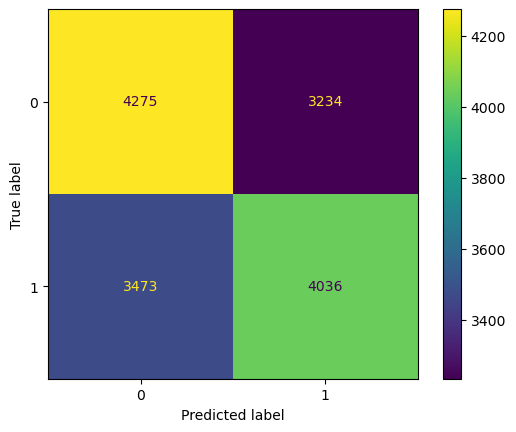

In [ ]:
for model_name, pipeline in ensemble_models.items():
    print(f"** Evaluating {model_name} on SSAE Encoded Data: ")
    evaluate_model(pipeline, X_train, X_test, y_train, y_test)

    X_test_encoded_ssae = pipeline.named_steps['ssae'].transform(X_test)
    X_train_encoded_ssae = pipeline.named_steps['ssae'].transform(X_train)

    print(f"** Evaluating {model_name}'s Shapley Value (TreeExplainer): ")
    evaluate_models_shap2(pipeline.named_steps['model'], X_test_encoded_ssae)

In [ ]:
for model_name, pipeline in tabnet_model.items():
    print(f"** Evaluating {model_name} on SSAE Encoded Data: ")
    evaluate_model(pipeline, X_train, X_test, y_train, y_test)

    X_test_encoded_ssae = pipeline.named_steps['ssae'].transform(X_test)
    X_train_encoded_ssae = pipeline.named_steps['ssae'].transform(X_train)

    print(f"** Evaluating {model_name}'s Shapley Value (TreeExplainer): ")
    evaluate_models_shap_tabnet(pipeline.named_steps['model'], X_test_encoded_ssae)